In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [3]:
def string_number_encoder(y):
    res = np.zeros(len(y))
    for j, clss in enumerate(np.unique(y)):
        res[y == clss] = j
    return res


In [4]:
class Logistic_Regression:
    def __init__(self,randomstate = 42,  intercept = False,  n_iter = 1e3, lr=1e-3, regularisation = None, alpha = None, multiclass = False):
        np.random.seed(randomstate)
        self.intercept = intercept
        self.multiclass = multiclass
        self.n_iter = n_iter
        self.lr = lr
        self.regular = regularisation
        self.alpha = alpha
        self.losses=[]
        if (self.regular != None and self.alpha == None) or (self.regular not in ['ridge', 'lasso'] and self.regular != None):
            raise Exception(f'Invalid Combination of Hyperparameters: \n\tregularisation: {self.regular} and alpha: {self.alpha} are not a valid hyperparameter combination')
    def fit(self, X, y, lr = 0.01, n_iters = 1000):
        # print(X.shape)
        if not self.intercept:
            X = np.concatenate((np.ones((len(X))).reshape(-1,1), X), axis = 1)
        self.N, self.D = X.shape
        self.X = X
        if self.multiclass == False:
            w = np.zeros(self.D)
            self.grad_des(w, y)
        if self.multiclass == True:
            I = self.OneHotEncode(y)
            w = np.random.randn(self.D, I.shape[1])
            self.grad_des(w, I)
    def grad_des(self, w, y):
        for epoch in range(int(self.n_iter)):
            if self.multiclass:
                yhat = self.softmax_row(self.X @ w) + 1e-15
            else:
                yhat = self.logistic(self.X @ w) + 1e-15
            CE = (-np.sum(y * np.log(yhat)))/self.N
            if self.multiclass == False:
                CE = -np.sum((y*np.log(yhat) + (1-y)*np.log(1-yhat)))/self.N
            grad = -self.X.T @ (y - yhat)
            if self.regular == 'ridge':
                grad = grad + self.alpha * w
            elif self.regular == 'lasso':
                grad = grad + self.alpha * np.sign(w)
            w -= self.lr * grad
            self.losses.append(CE)
            # print(f'epoch: {epoch}, logloss: {CE},')
        self.w = w

        
    def predict(self, X_test):
        if not self.intercept:
            X_test = np.concatenate((np.ones((len(X_test))).reshape(-1,1), X_test), axis = 1)
        lincomb = X_test @ self.w
        if self.multiclass:
            p = self.softmax_row(lincomb)
            yhat = np.argmax(p, axis = 1)
        else:
            yhat = self.logistic(lincomb).round()
        return yhat
    def softmax_row(self, y):
        return (np.exp(y)/(np.exp(y).sum(1)[:,None]))
    def OneHotEncode(self, y):
        I = np.zeros(shape = (len(y), len(np.unique(y))), dtype = int)
        for j, target in enumerate(np.unique(y)):
            I[:,j] = (y == target)
        return I

    def logistic(self, y):
        return (1 + np.exp(-y))**(-1)

In [5]:
import pandas as pd

In [9]:
iris = pd.read_csv("Iris.csv").drop('Id', axis = 1)
X = iris.iloc[:, :-1].values
y = iris.iloc[:, -1].values
iris.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Iris.csv'

In [10]:
sns.pairplot(iris,  hue='Species')
plt.show()

NameError: name 'iris' is not defined

In [208]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = string_number_encoder(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

In [209]:
LR = Logistic_Regression(multiclass=True, n_iter=500, lr = 0.008, randomstate=42)
LR.fit(X_train, y_train)

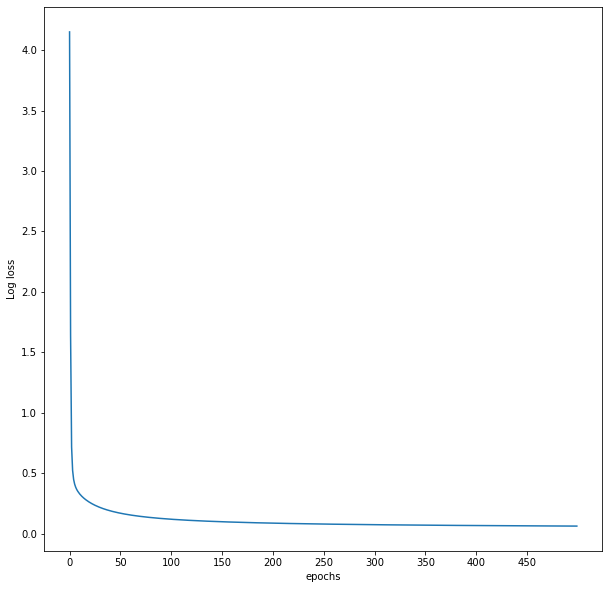

In [210]:
plt.figure(figsize=(10,10))
plt.plot(range(0,len(LR.losses)),LR.losses)
plt.ylabel("Log loss")
plt.xlabel("epochs")
locs,labels=plt.xticks(range(0,len(LR.losses),50))

In [211]:
ypred = LR.predict(X_test)

In [212]:
sk_ypred = LogisticRegression(max_iter=500,multi_class="multinomial").fit(X_train, y_train).predict(X_test)

In [213]:
from sklearn.metrics import precision_score, recall_score, f1_score,classification_report
custom_precision = precision_score(y_test, ypred, average='macro')
sk_precision = precision_score(y_test, sk_ypred, average='macro')
custom_precision, sk_precision

(0.9696969696969697, 0.9333333333333332)

In [214]:
custom_recall = recall_score(y_test, ypred, average='macro')
sk_recall = recall_score(y_test, sk_ypred, average='macro')
custom_recall, sk_recall

(0.9666666666666667, 0.9333333333333332)

In [215]:
custom_f1 = f1_score(y_test, ypred, average='macro')
sk_f1 = f1_score(y_test, sk_ypred, average='macro')
custom_f1, sk_f1

(0.9665831244778613, 0.9333333333333332)

In [216]:
print(classification_report(y_test,ypred,target_names=["Setosa","Veriscolor","Virginica"]))

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        10
  Veriscolor       1.00      0.90      0.95        10
   Virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [217]:
print(classification_report(y_test,sk_ypred,target_names=["Setosa","Veriscolor","Virginica"]))

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        10
  Veriscolor       0.90      0.90      0.90        10
   Virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



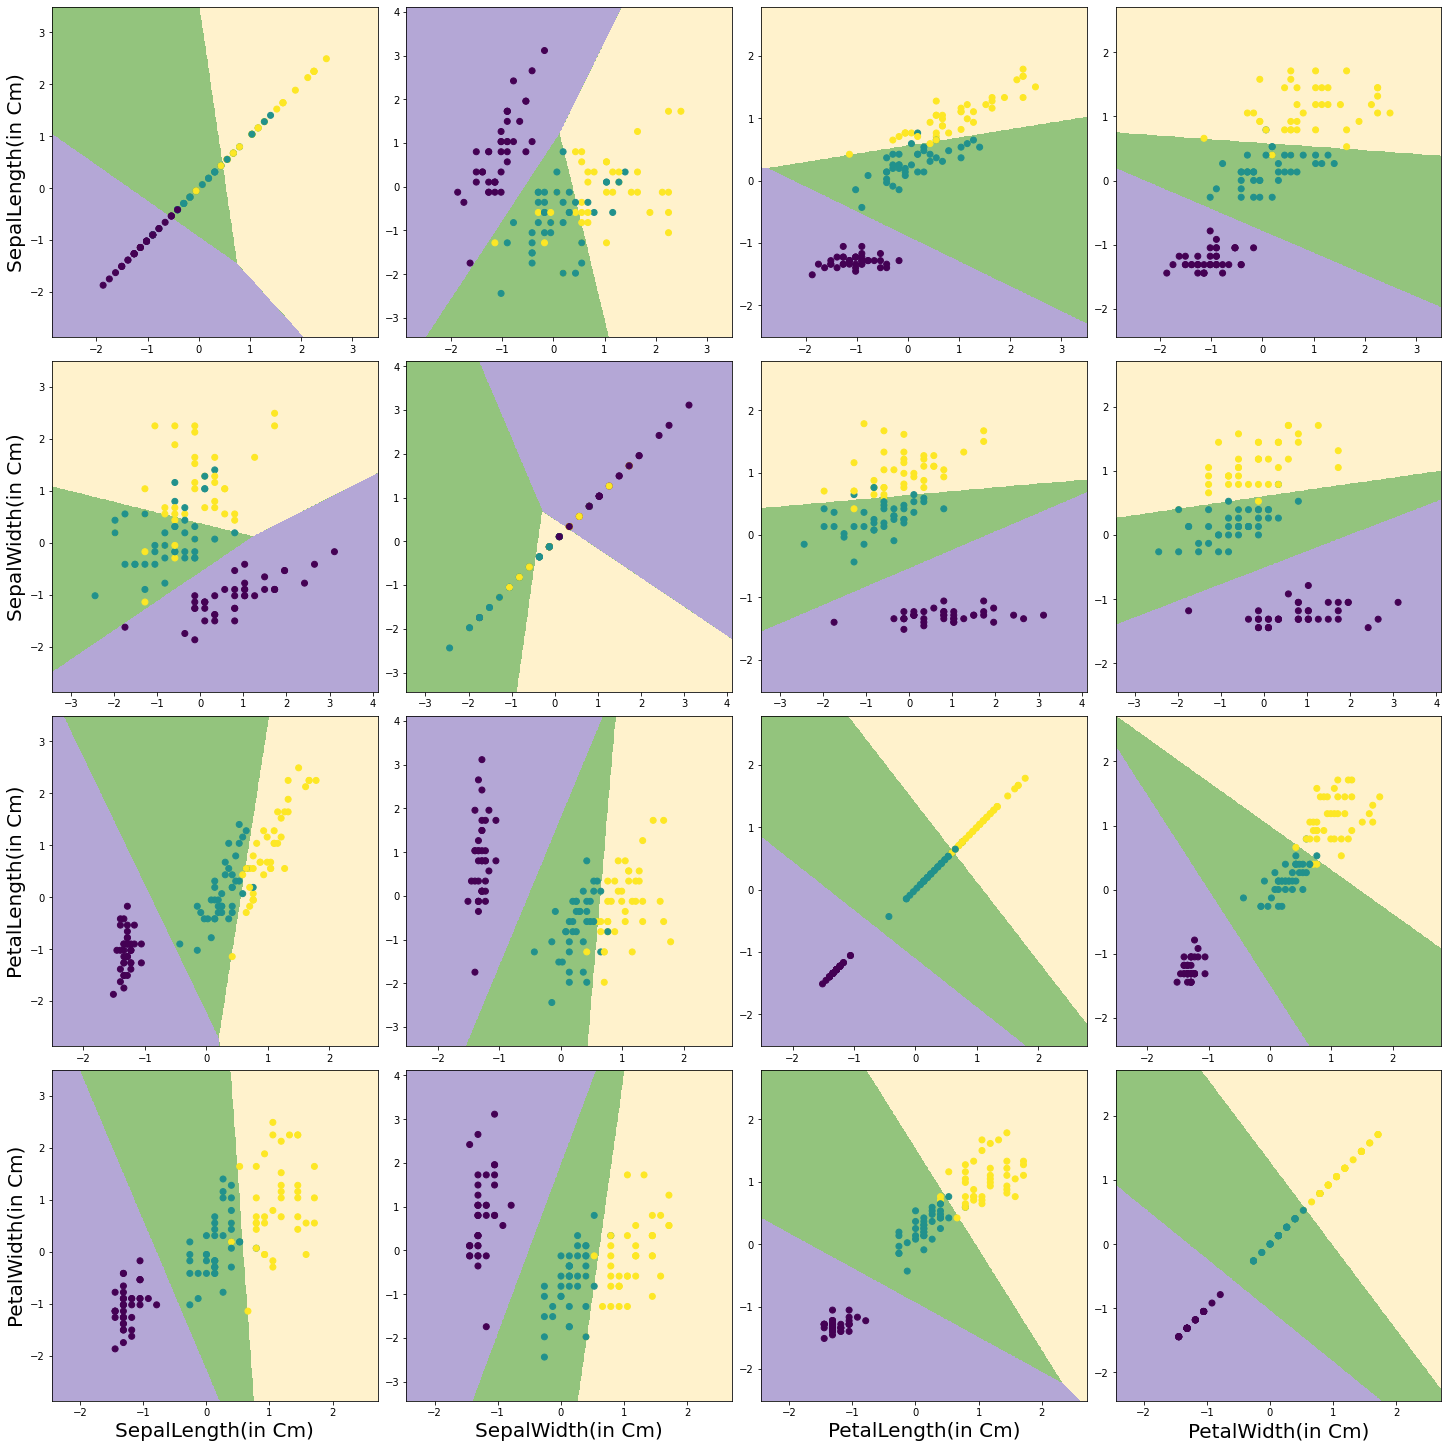

In [220]:
from matplotlib.colors import ListedColormap

feature_names=['SepalLength(in Cm)','SepalWidth(in Cm)','PetalLength(in Cm)','PetalWidth(in Cm)']
custom_cmap = ListedColormap(['#b4a7d6','#93c47d','#fff2cc'])
fig, ax = plt.subplots(4, 4, figsize=(20, 20),constrained_layout=True)
formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
for i in range(4):
    for j in range(4):
        LRR=Logistic_Regression(multiclass=True, n_iter=500, lr = 0.008, randomstate=42)
        # LRR=LogisticRegression(max_iter=100)
        LRR.fit(X_train[:,[i,j]],y_train)
        x0, x1 = np.meshgrid(
            np.linspace(X_train[:, i].min()-1, X_train[:, i].max()+1, 500).reshape(-1, 1),
            np.linspace(X_train[:, j].min()-1, X_train[:, j].max()+1, 500).reshape(-1, 1)
        )

        X_new = np.c_[x0.ravel(), x1.ravel()]
        y_pred = LRR.predict(X_new)
        zz = y_pred.reshape(x0.shape)

        ax[i][j].contourf(x0, x1, zz, cmap=custom_cmap)
        ax[i][j].scatter(X_train[:, i], X_train[:, j], c=y_train)
       
        # Set the labels for the x and y axes
        if i==3:ax[i][j].set_xlabel(feature_names[j],fontsize=20)
        if j==0:ax[i][j].set_ylabel(feature_names[i],fontsize=20)
# plt.colorbar(scatter)
plt.show()


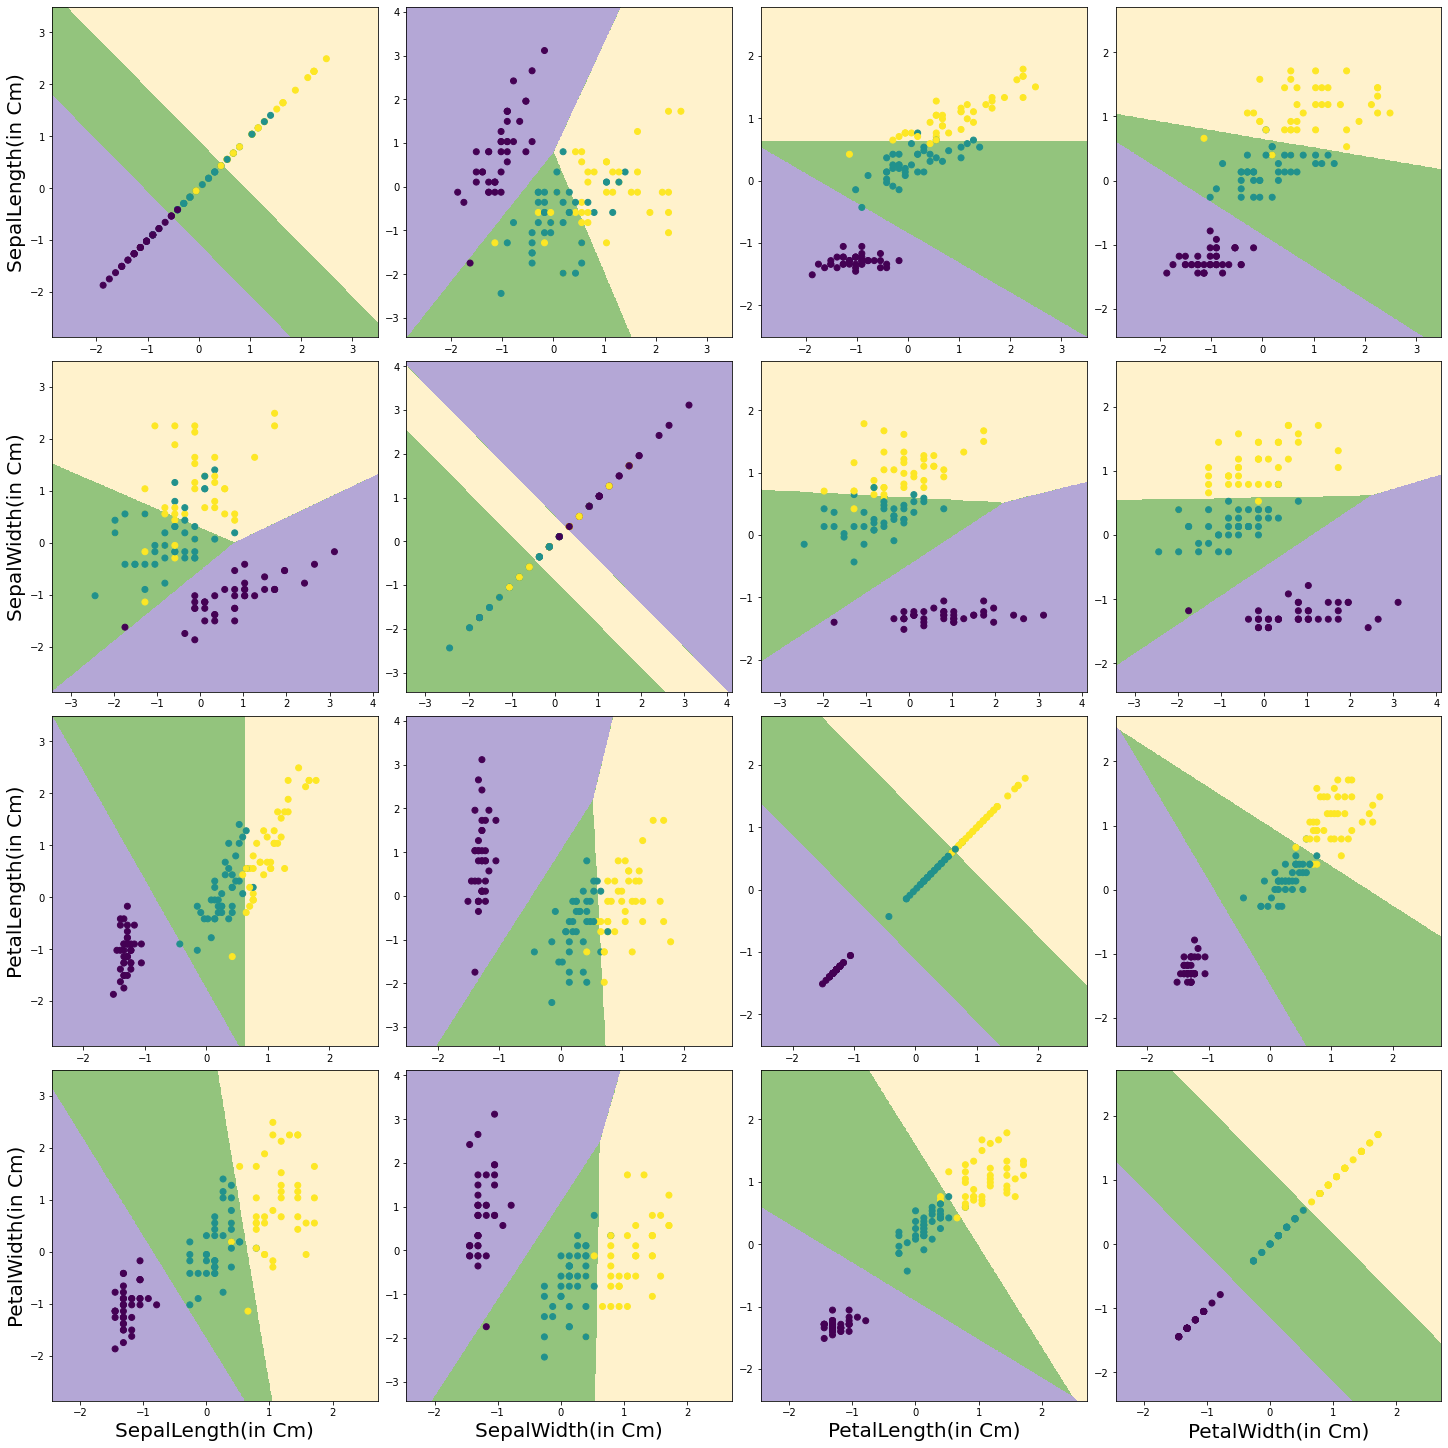

In [221]:
from matplotlib.colors import ListedColormap

feature_names=['SepalLength(in Cm)','SepalWidth(in Cm)','PetalLength(in Cm)','PetalWidth(in Cm)']
custom_cmap = ListedColormap(['#b4a7d6','#93c47d','#fff2cc'])
fig, ax = plt.subplots(4, 4, figsize=(20, 20),constrained_layout=True)
formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
for i in range(4):
    for j in range(4):
        # LRR=Logistic_Regression(multiclass=True, n_iter=1000, lr = 0.008, randomstate=42)
        LRR=LogisticRegression(max_iter=500)
        LRR.fit(X_train[:,[i,j]],y_train)
        x0, x1 = np.meshgrid(
            np.linspace(X_train[:, i].min()-1, X_train[:, i].max()+1, 500).reshape(-1, 1),
            np.linspace(X_train[:, j].min()-1, X_train[:, j].max()+1, 500).reshape(-1, 1)
        )

        X_new = np.c_[x0.ravel(), x1.ravel()]
        y_pred = LRR.predict(X_new)
        zz = y_pred.reshape(x0.shape)

        ax[i][j].contourf(x0, x1, zz, cmap=custom_cmap)
        ax[i][j].scatter(X_train[:, i], X_train[:, j], c=y_train)
       
        # Set the labels for the x and y axes
        if i==3:ax[i][j].set_xlabel(feature_names[j],fontsize=20)
        if j==0:ax[i][j].set_ylabel(feature_names[i],fontsize=20)
# plt.colorbar(scatter)
plt.show()
